<a href="https://colab.research.google.com/github/pedrogasg/models-katas/blob/master/MixtureOfLogistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [132]:
def sample_data_1():
    count = 10000
    rand = np.random.RandomState(0)
    a = 0.4 + 0.15 * rand.randn(count)
    b = 0.7 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    data = np.digitize(samples, np.linspace(0.0, 1.0, 100))
    split = int(0.8 * len(data))
    train_data, test_data = data[:split], data[split:]
    return train_data, test_data

In [133]:
def plot_data(train_data, test_data, bins=100):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_figheight(5)
  fig.set_figwidth(15)
  ax1.set_title('Train Data')
  ax1.hist(train_data, bins=np.arange(bins) - 0.5, density=True)
  ax1.set_xlabel('x')
  ax2.set_title('Test Data')
  ax2.hist(test_data, bins=np.arange(bins) - 0.5, density=True)
  plt.show()

In [134]:
def plot_hist(data, bins=10, xlabel='x', ylabel='Probability', title='', density=None):
    bins = np.concatenate((np.arange(bins) - 0.5, [bins - 1 + 0.5]))

    plt.figure()
    plt.hist(data, bins=bins, density=True)

    if density:
        plt.plot(density[0], density[1], label='distribution')
        plt.legend()

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [135]:
train_data, test_data  = sample_data_1()

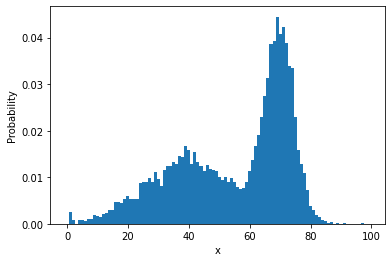

In [136]:
plot_hist(train_data, bins=100)

In [137]:
ds = tf.data.Dataset.from_tensor_slices(train_data)
ds = ds.shuffle(1000).batch(128, drop_remainder=True)

In [138]:
class MixtureOfLogistics(tf.keras.layers.Layer):
  def __init__(self, d, n_mix=4):
    super(MixtureOfLogistics, self).__init__()
    self.d = d
    self.n_mix = n_mix
    self.logits = self.add_weight(shape=(n_mix,), initializer="zeros", trainable=True)
    self.means = tf.Variable(shape=(n_mix,), initial_value=tf.range(0,limit=n_mix, dtype=tf.dtypes.float32) / (n_mix - 1) * d, trainable=True)
    self.log_scales = self.add_weight(shape=(n_mix,), initializer="random_normal", trainable=True)
    self.x = tf.Variable(initial_value=tf.linspace(-0.5, d - 1 + 0.5, 1000), trainable=False)

  def call(self, inputs):
    x = tf.expand_dims(inputs, axis=1)
    x = tf.cast(tf.tile(x,(1, self.n_mix)), dtype=tf.dtypes.float32)
    means = tf.expand_dims(self.means, axis=0)
    log_scales = tf.expand_dims(self.log_scales, axis=0)
    inv_scales = tf.exp(-log_scales)
    
    plus_in = inv_scales * (x + 0.5 - means)
    min_in = inv_scales * (x - 0.5 - means)

    cdf_plus = tf.sigmoid(plus_in)
    cdf_min = tf.sigmoid(min_in)

    cdf_delta = cdf_plus - cdf_min

    log_cdf_delta = tf.math.log(tf.clip_by_value(cdf_delta, clip_value_min=1e-12, clip_value_max=0.1))
    log_cdf_plus = tf.sigmoid(inv_scales * (0.5 - means))
    log_cdf_min = tf.sigmoid(inv_scales * (d - 1.5 - means))

    x_log_probs = tf.where(x < 0.001, log_cdf_plus, tf.where(x > d - 1 - 1e-3, log_cdf_min, log_cdf_delta))
    pi_log_probs = tf.expand_dims(tf.nn.log_softmax(self.logits, axis=0), axis=0)
    log_probs = x_log_probs + pi_log_probs
    l1 = tf.math.reduce_logsumexp(log_probs, axis=1)
    loss = -tf.math.reduce_mean(l1)
    return loss

  def get_density(self):
    x_pt = tf.expand_dims(tf.cast(self.x, dtype=tf.dtypes.float32), axis=1)
    means = tf.expand_dims(self.means, axis=0)
    log_scales = tf.expand_dims(self.log_scales, axis=0)
    pi_log_probs = tf.expand_dims(tf.nn.log_softmax(self.logits, axis=0), axis=0)

    x_in = (x_pt - means) * tf.exp(-log_scales)
    log_pdf = x_in - log_scales - 2 * tf.math.softplus(x_in)
    log_pdf = log_pdf + pi_log_probs
    log_pdf = tf.math.reduce_logsumexp(log_pdf, axis=1)
    y = tf.exp(log_pdf).numpy()
    return self.x.numpy(), y


In [139]:
def train(model, dataset, optimizer):
  model.trainable = True
  for x in dataset:
    with tf.GradientTape() as tape:
      loss = model(x)
      grads = tape.gradient(loss, model.trainable_weights)

      optimizer.apply_gradients(zip(grads, model.trainable_weights))

In [140]:
d = 100
mol = MixtureOfLogistics(d)

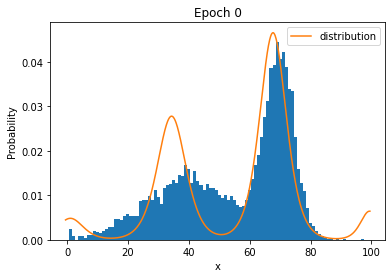

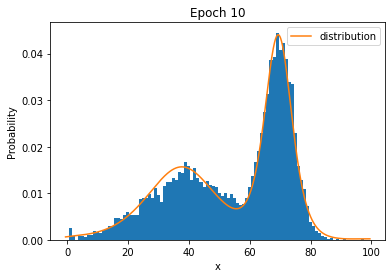

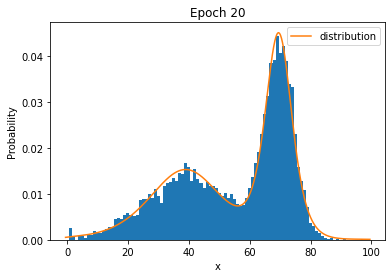

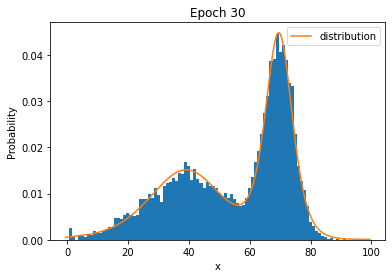

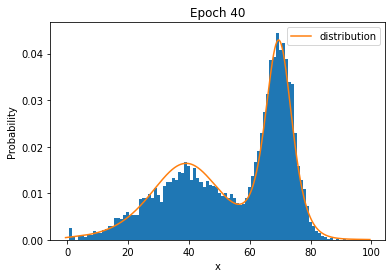

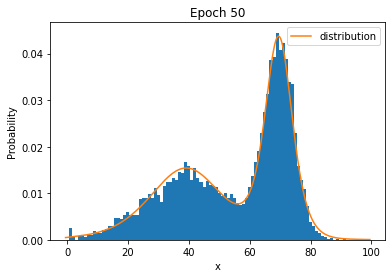

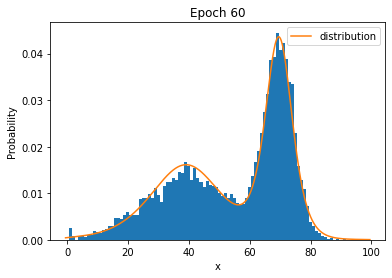

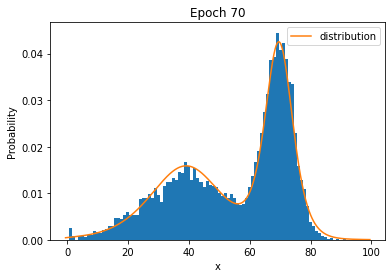

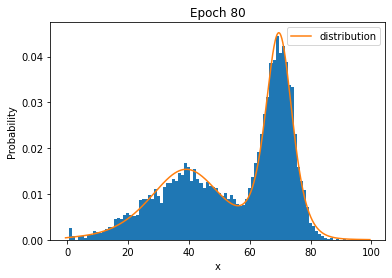

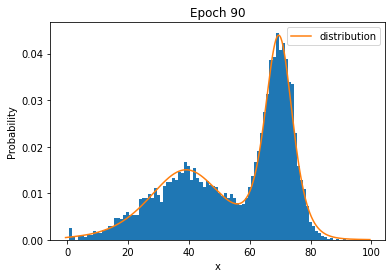

In [141]:
epochs=100
lr=2.5e-2
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
for epoch in range(epochs):
  train(mol, ds, optimizer)
  if epoch % 10 == 0:
    plot_hist(train_data, bins=d,
                      title=f'Epoch {epoch}', density=mol.get_density())